In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential, model_from_json
from keras.layers import Dense, Input
from keras.models import Model
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
#file path retrieve
data_dir = Path('/Users/joshua/chest_xray/')

In [3]:
n_train = data_dir.glob('train/NORMAL/*.jpeg')
p_train = data_dir.glob('train/PNEUMONIA/*.jpeg')
n_test = data_dir.glob('test/NORMAL/*.jpeg')
p_test = data_dir.glob('test/PNEUMONIA/*.jpeg')

In [4]:
def data_to_df(norm,pneu):
    data = []
    for img in norm:
        data.append((str(img),0))
    for img in pneu:
        data.append((str(img),1))
    data = pd.DataFrame(data, columns=['filepath', 'label'],index=None)
    # shuffle data
    data = data.sample(frac=1.).reset_index(drop=True)
    return data

In [5]:
train_data = data_to_df(n_train,p_train)
test_data = data_to_df(n_test,p_test)

In [6]:
def case_count(data):
    data['label'].value_counts()

In [7]:
case_count(train_data)
#pneumonia    3875
#normal    1341

Inbalanced train_data: 

normal count: 1341

pneumonia count: 3875

In [8]:
#make a dataframe of normal images for data augmentation
norm_train = train_data[train_data['label']==0]
norm_train.reset_index(drop=True, inplace=True)

In [9]:
#set the image size to 160
image_size = 160

In [10]:
#double the normal count by flip the image left and right/up and down
def data_augmentation(dataset):
    data = []
    for i in range(len(dataset)):
        image = cv2.imread(dataset['filepath'][i])
        image_1 = tf.image.flip_left_right(image)
        image_2 = tf.image.flip_up_down(image)
        image_1 = asarray(image_1)
        image_2 = asarray(image_2)
        image_1 = cv2.resize(image_1, (image_size, image_size))
        image_1 = np.dstack([image_1, image_1, image_1])
        image_2 = cv2.resize(image_2, (image_size, image_size))
        image_2 = np.dstack([image_2, image_2, image_2])
        data.append([image_1, 0])
        data.append([image_2, 0])
    return data

In [11]:
data_aug = data_augmentation(norm_train)

2022-07-17 22:51:46.094244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
#data preprocessing
def data_preprocess(dataset):
    data = []
    for i in range(len(dataset)):
        image = cv2.imread(dataset['filepath'][i])
        image = cv2.resize(image, (image_size, image_size))
        image = np.dstack([image, image, image])
        data.append([image, dataset['label'][i]])
    return data


In [13]:
train = data_preprocess(train_data)

In [14]:
#add augmented normal images to training dataset
train = train + data_aug

In [15]:
#Separating the images and labels
def separate(dataset):
    img = []
    label = []
    for i in dataset:
        img.append(i[0])
        label.append(i[1])
    img = np.array(img)
    label = np.array(label)
    #dataset[0] for image, dataset[1] for labels
    return img,label 

In [16]:
training = separate(train)

In [17]:
#make model for prediction
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 9)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='sigmoid')
])

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [28]:
#dataset[0] for image, dataset[1] for labels
model.fit(training[0], training[1], epochs=10, batch_size=100)

Epoch 1/10
79/79 [==============================] - 123s 2s/step - loss: 0.0196 - accuracy: 0.9924
Epoch 2/10
79/79 [==============================] - 122s 2s/step - loss: 0.0119 - accuracy: 0.9958
Epoch 3/10
79/79 [==============================] - 123s 2s/step - loss: 0.0079 - accuracy: 0.9976
Epoch 4/10
79/79 [==============================] - 122s 2s/step - loss: 0.0056 - accuracy: 0.9986
Epoch 5/10
79/79 [==============================] - 141s 2s/step - loss: 0.0034 - accuracy: 0.9994
Epoch 6/10
79/79 [==============================] - 142s 2s/step - loss: 0.0025 - accuracy: 0.9995
Epoch 7/10
79/79 [==============================] - 140s 2s/step - loss: 0.0014 - accuracy: 0.9997
Epoch 8/10
79/79 [==============================] - 141s 2s/step - loss: 8.6260e-04 - accuracy: 1.0000
Epoch 9/10
79/79 [==============================] - 140s 2s/step - loss: 5.7778e-04 - accuracy: 1.0000
Epoch 10/10
79/79 [==============================] - 142s 2s/step - loss: 4.2176e-04 - accuracy: 1.00

In [29]:
#test data preprocessing
test = data_preprocess(test_data)
testing = separate(test)
#dataset[0] for image, dataset[1] for labels
model.evaluate(testing[0], testing[1])
preds = model.predict(testing[0], batch_size=32)
preds = np.argmax(preds, axis=-1)

20/20 [==============================] - 3s 125ms/step


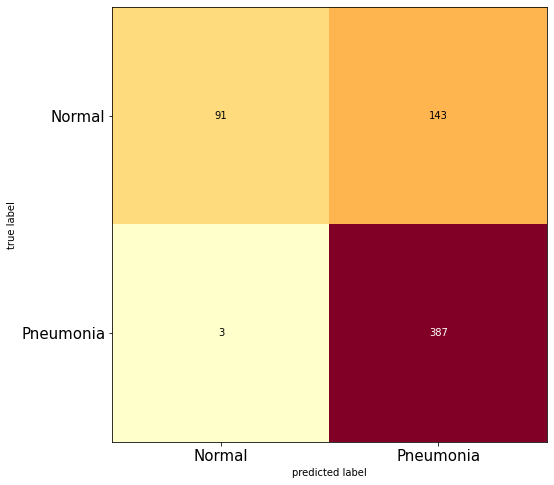

In [30]:
#configure confusion matrix for test data
cm  = confusion_matrix(testing[1], preds)
plot_confusion_matrix(cm,figsize=(15,8), hide_ticks=True,cmap=plt.cm.YlOrRd)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.show()

The test results show that the model predict 143 'normal' images wrongly to the pneumonia category (False positive). However only 3 images are wrongly categorized to normal when it's 'pneumonia'. "its better to be healthy and falsely checked as pneumonia than having pneumonia and categorized as 'normal"

In [32]:
tn, fp, fn, tp = cm.ravel()
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn)
print("Accuracy {:0.2f} %".format(Accuracy))

#Precision
Precision = tp/(tp+fp)
print("Precision {:0.2f}".format(Precision))

#Recall 
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

Accuracy 76.60 %
Precision 0.73
Recall 0.99


Low testing accuracy possible cause: The training data is inbalanced with more 'pneumonia' image than 'normal', even though the data are augmented.

In [34]:
#save model to json file for api to retrieve
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
